In [1]:
!git clone https://github.com/GianinaCosmina/Teeth-Detection.git

# These codes are just demo . Not include all paper . 

Cloning into 'Teeth-Detection'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 4), reused 39 (delta 4), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

In [4]:
import sys
sys.path.append("/content/Teeth-Detection")

In [6]:
%cd /content/Teeth-Detection
#!pip install -qr requirements.txt
#You can  use pip install however colab includes all libraries so we dont need them

/content/Teeth-Detection


In [7]:
from download_dataset import *
import os
path = "/content/Data"
if os.path.exists(path+'/DentalPanoramicXrays.zip') == False:
  os.mkdir(path)
  download_dataset(path+'/')

Downloading...
Completed...


In [10]:
from images_prepare import *
#pre_images(resize_shape,path,include_zip)
path = "/content/Data"
X,X_sizes=pre_images((512,512),path,True)

In [9]:
from masks_prepare import *
#Y=pre_masks(resize_shape=(512,512),path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Original_Masks')  ORIGINALL MASKS function 
Y=pre_splitted_masks(path='/content/Teeth-Detection/Custom_Masks') #Custom Splitted MASKS size 512x512


In [11]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [12]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
!pip install opencv-python-headless==4.5.2.52

In [16]:
import cv2

import albumentations as A
#Augmention . Change what you want ! Care about Your GPU and CPU RAM

#If you get error : cannot import name '_registerMatType' from 'cv2.cv2' :
#!pip uninstall opencv-python-headless==4.5.5.62
#!pip install opencv-python-headless==4.5.2.52

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT), 
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1580: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [17]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [21]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

22


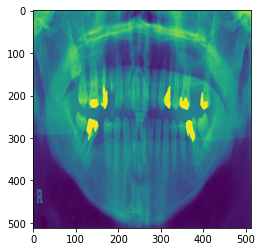

In [22]:
#Checking data X  and Y matching
plt.imshow(x_train[random_number,:,:,0])

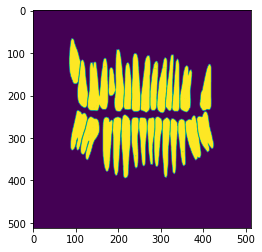

In [23]:
#Checking data X  and Y matching
plt.imshow(y_train[random_number,:,:,0])

In [ ]:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

In [25]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch 
model.fit(x_train,y_train,batch_size=8,epochs=10,verbose=1)

Epoch 1/10
66/66 [==============================] - 97s 1s/step - loss: 0.3504 - accuracy: 0.7967
Epoch 2/10
66/66 [==============================] - 70s 1s/step - loss: 0.2226 - accuracy: 0.8552
Epoch 3/10
66/66 [==============================] - 69s 1s/step - loss: 0.1920 - accuracy: 0.8678
Epoch 4/10
66/66 [==============================] - 69s 1s/step - loss: 0.1889 - accuracy: 0.8688
Epoch 5/10
66/66 [==============================] - 69s 1s/step - loss: 0.1727 - accuracy: 0.8754
Epoch 6/10
66/66 [==============================] - 69s 1s/step - loss: 0.1645 - accuracy: 0.8790
Epoch 7/10
66/66 [==============================] - 69s 1s/step - loss: 0.1650 - accuracy: 0.8788
Epoch 8/10
66/66 [==============================] - 70s 1s/step - loss: 0.1500 - accuracy: 0.8847
Epoch 9/10
66/66 [==============================] - 70s 1s/step - loss: 0.1488 - accuracy: 0.8857
Epoch 10/10
66/66 [==============================] - 69s 1s/step - loss: 0.1468 - accuracy: 0.8858


In [26]:
predict_img=model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0] 

1/1 [==============================] - 10s 10s/step


In [ ]:
#Example Test
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9528451399369673

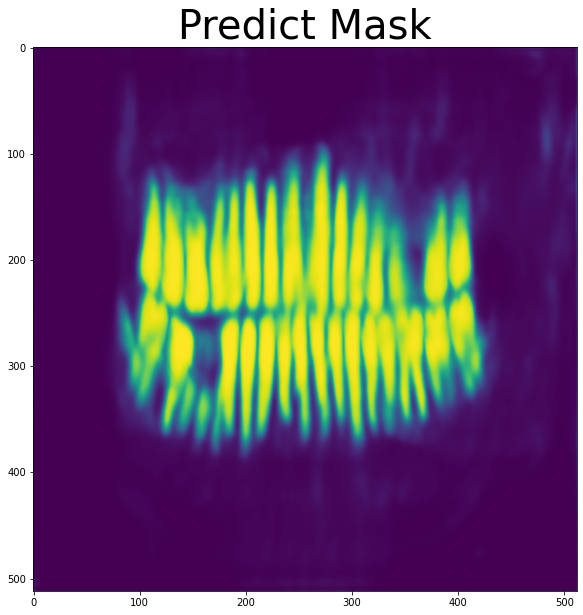

In [27]:

plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("/content/predict.png",predict)

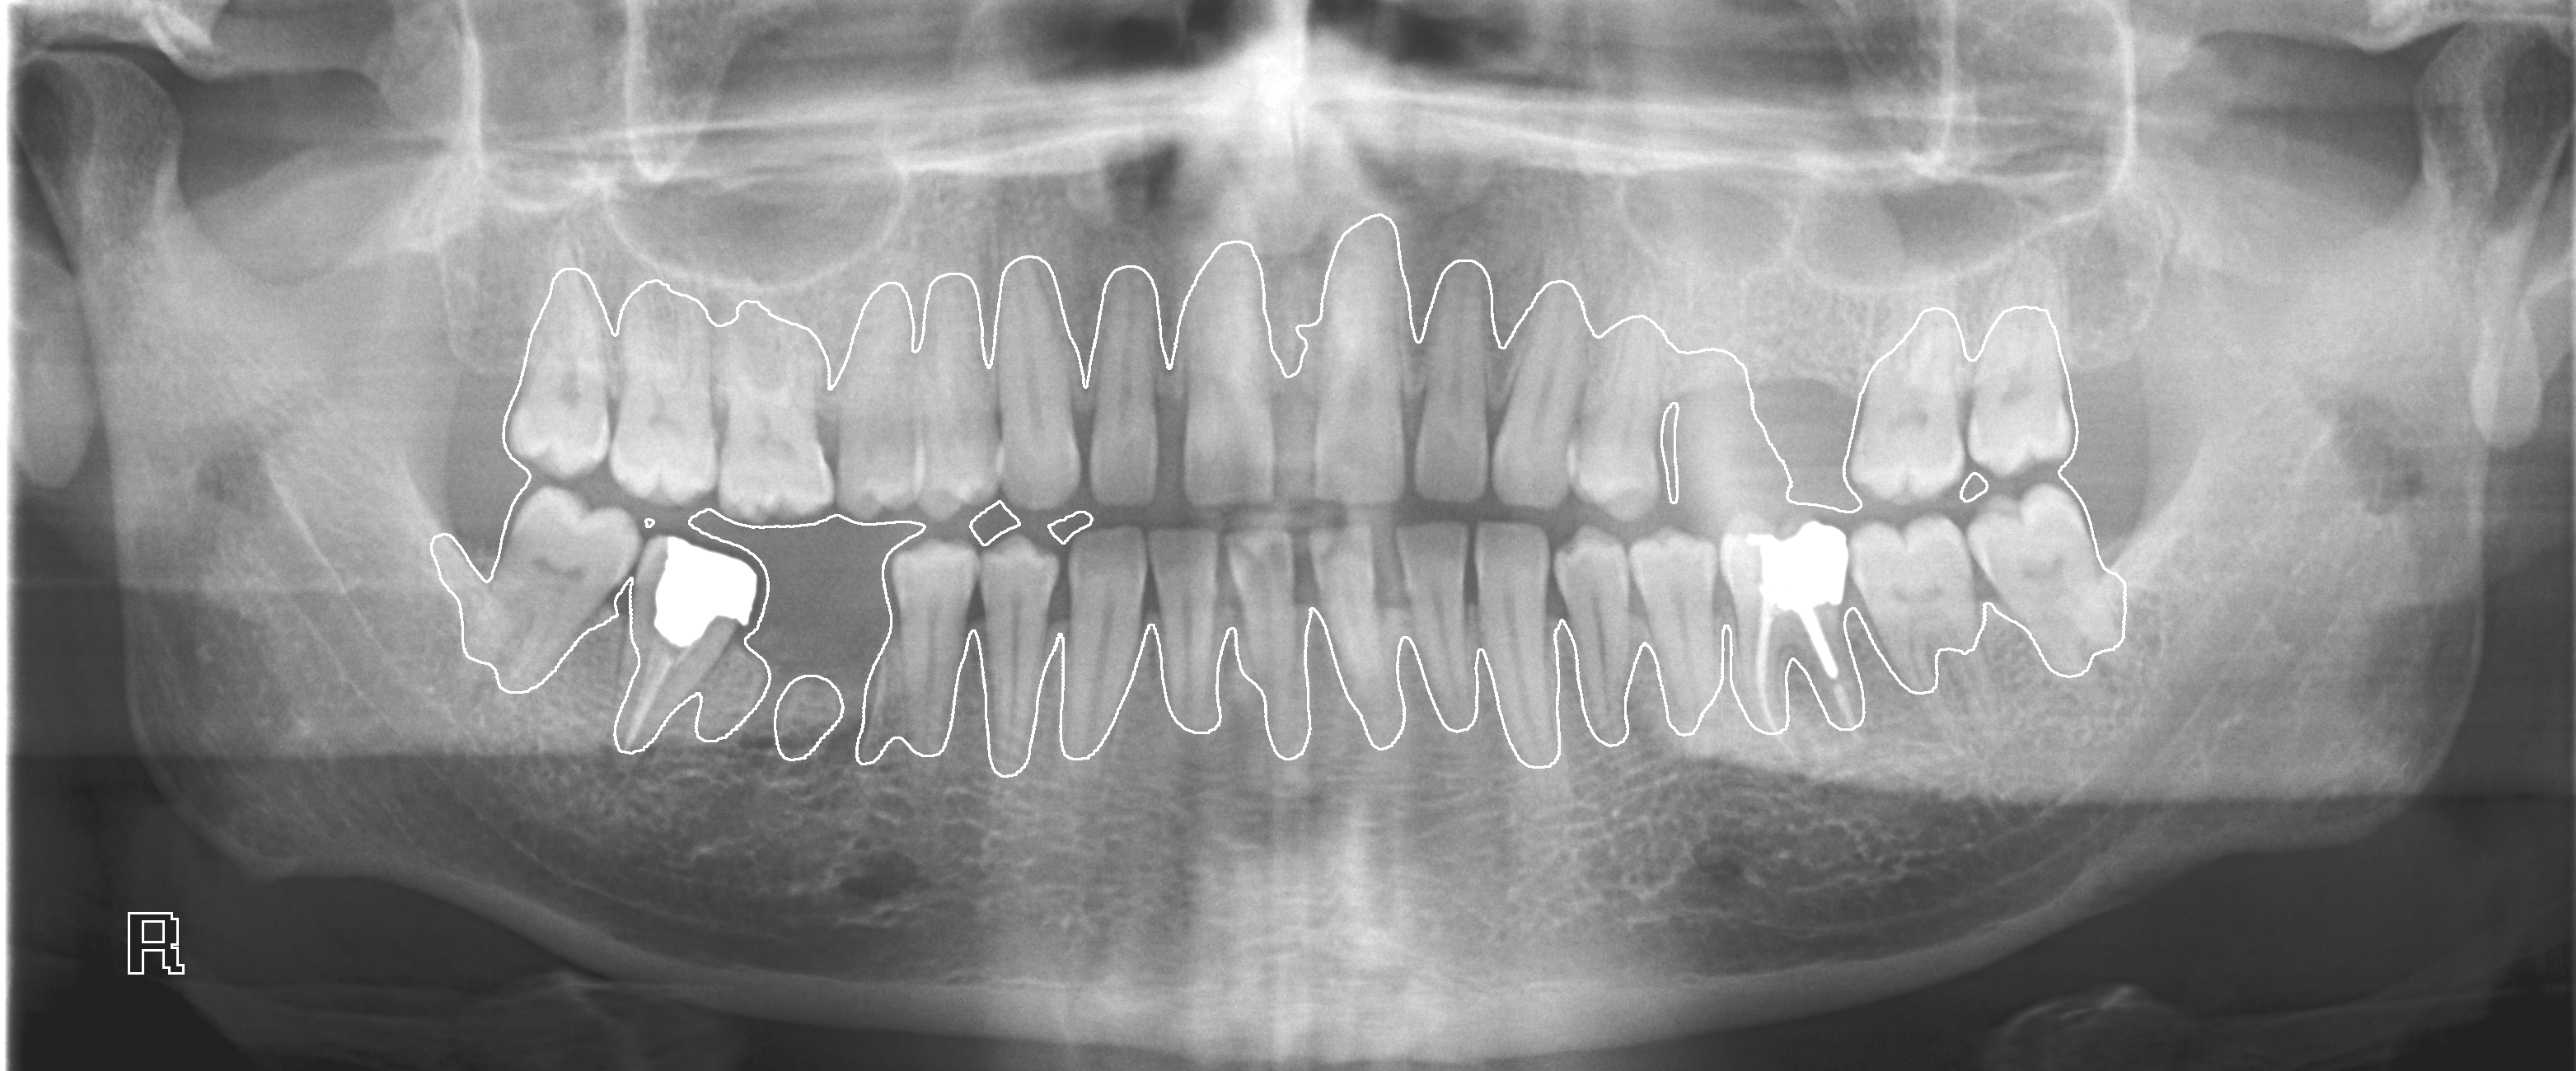

In [28]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png 

predict1 = cv2.resize(predict, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

mask=np.uint8(predict1*255)# 
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)
cnts,hieararch=cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(cv2.UMat(img[:,:,0]), cnts, -1, (255, 0, 0) , 2)
img = cv2.UMat.get(img)
cv2_imshow(img)

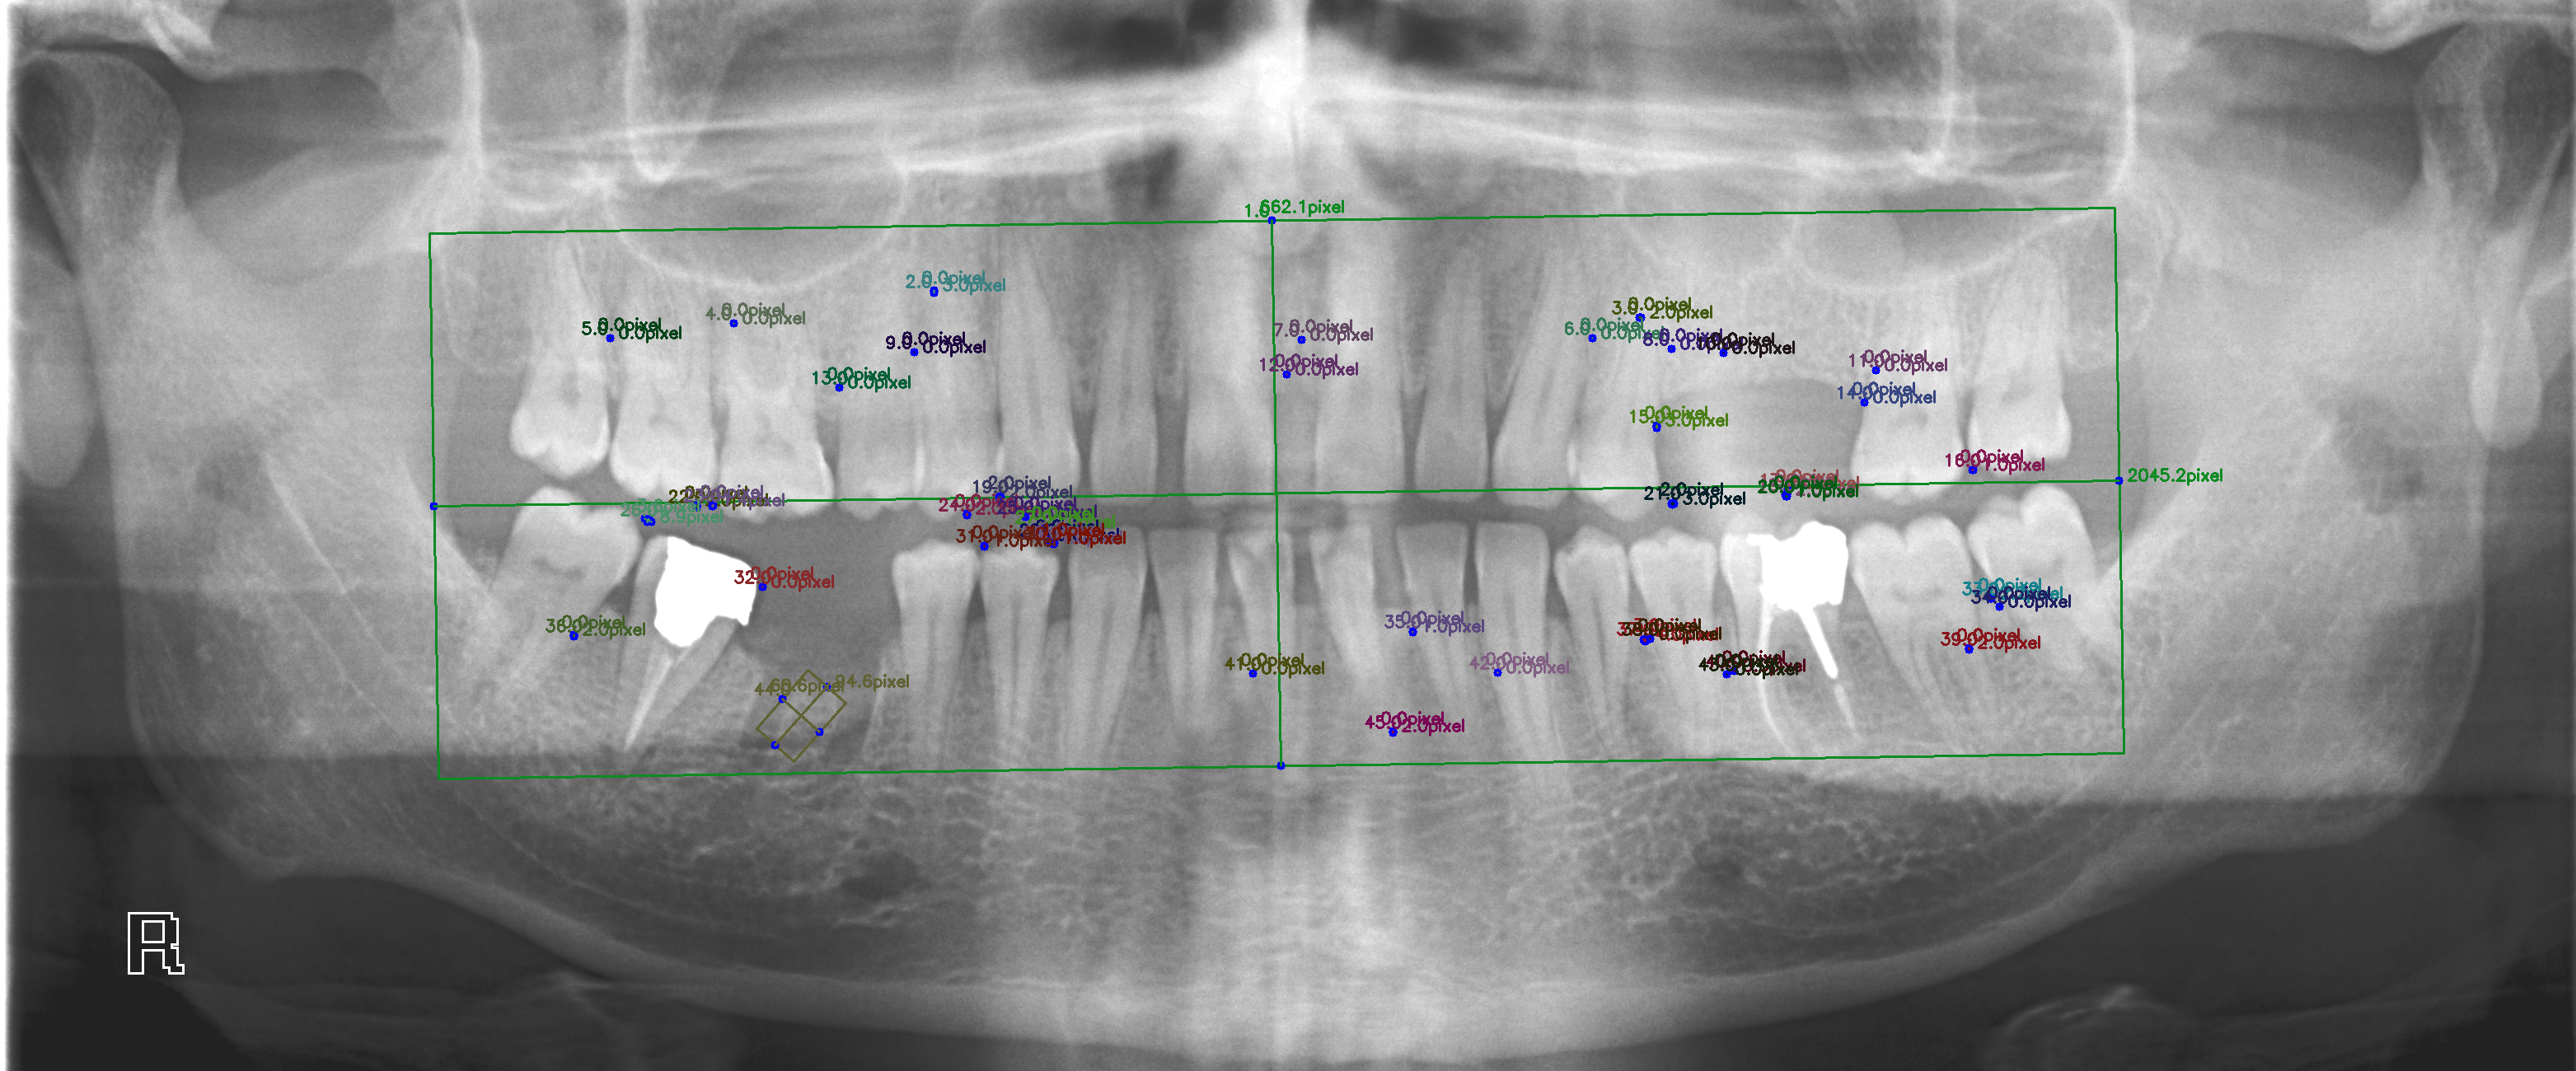

In [29]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example with CCA_Analysis
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png 

#load image (mask was saved by matplotlib.pyplot) 
predicted=cv2.imread("/content/predict.png")

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
cv2_imshow(cca_result)

In [ ]:
print(teeth_count,"Teeth Count")

30 Teeth Count


In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.h5')

In [30]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=4fd2847c1d78ee324a733636b229d58682b975fb851345769c04e679c185cd50
  Stored in directory: /root/.cache/pip/wheels/ea/f9/a1/34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Successfully built ws4py


In [31]:
import anvil.server

anvil.server.connect("X4D6NLG34YNOA6TM7Q2J4EWN-T3IPCXFQWW4PSGYC")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [32]:
import anvil.media
import base64
import io
from PIL import Image
import tensorflow
from tensorflow.keras.utils import load_img


@anvil.server.callable
def detect_problems(file):
  img = Image.open(io.BytesIO(file.get_bytes()))
  img.save("/content/uploaded.png")
  img=cv2.imread("/content/uploaded.png")

  predicted=cv2.imread("/content/predict.png")
  predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

  cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
  plt.imsave("/content/detected.png",cca_result)

  with open("/content/detected.png", "rb") as image_file:
     encoded_string = base64.b64encode(image_file.read())
  image_binary = base64.b64decode(encoded_string)
  my_media = anvil.BlobMedia(content_type="img/png", content=image_binary, name="detected")

  return my_media